# 545 Project - Movie recommender!
###### **Group members**: Kun Hwi Ho, Henry Tat Hang Hung, Huilin Liang



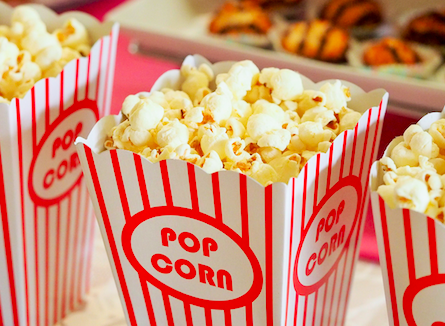

Kept browsing and looking but just couldn't find the next movie to watch to kill the time during quarantine? 
Recommendations from your favourite streaming platform not *really* working? ... We know that feeling. 

Introducing - our final project, a movie recommender built by analyzing not just YOUR watch history but also what people with similar interests as yours have watched. Our idea is to have something similar to "*people like you have also watched...*" for making recommendations. 

We hope that this recommender would lead you to interesting discoveries :) 

## Background & Overview

>
>
>
>
>

Our movie recommender is less about "movie clustering" but based on "user clustering". Assume that people with similar interests watch (and like) similar moives, by the user group one finds oneself in, we can make use of that piece of information to recommend movies. 

We will be using **"The Movies Dataset"** from Kaggle, which contains 45000 movies, 26 million ratings from 270000 users

The data analysis techniques used:
* **PCA** - for pre-processing
* **K-means clustering** - for dividing users into subgroups of interests preference & subsequent unsupervised machine learning

The entire project is broken down into 4 steps:

* Step 1 : Navigate through a movies dataset, and clean for necessary data 
* Step 2 : EDA / Visualize the data to get initial insights 
* Step 3 : Reformat the data to be compatible for machine learning 
* Step 4 : Use K-Means Clustering to forecast what movies users will like  

## Packages / Setup

In [ ]:
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

In [ ]:
%%capture 

# data cleaning and visualization packages 
!pip install pandasql
import collections 
import numpy as np 
import pandas as pd
import pandasql as ps 
import re 
import matplotlib.pyplot as plt 
import seaborn as sns  
import collections
import itertools
import ipywidgets as widgets
from IPython.display import display


# machine learning packages 
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize
from sklearn.decomposition import PCA 
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.metrics import davies_bouldin_score

The first thing to do is to connect with the Kaggle API.

In [ ]:
# Step 1 : install dependencies 
!pip install -q kaggle 

# Step 2 : create API Token from Kaggle and upload Kaggle.json 
# Instructions : https://www.kaggle.com/general/74235
from google.colab import files 
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kellyhuilinliang","key":"1122b3285bf559c6a2494083ddeada0a"}'}

In [ ]:
# Step 3: additional steps 
!mkdir ~/.kaggle 
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Step 4 : download the dataset 
# https://www.kaggle.com/rounakbanik/the-movies-dataset
!kaggle datasets download -d rounakbanik/the-movies-dataset

# Step 5 : Unzip the files 
!unzip the-movies-dataset.zip

 97% 220M/228M [00:01<00:00, 118MB/s]
100% 228M/228M [00:01<00:00, 131MB/s]
Archive:  the-movies-dataset.zip
  inflating: credits.csv             
  inflating: keywords.csv            
  inflating: links.csv               
  inflating: links_small.csv         
  inflating: movies_metadata.csv     
  inflating: ratings.csv             
  inflating: ratings_small.csv       


## Step 1: Data Cleansing

From the Kaggle dataset, we are interested in three different datasets for our our analyses and for building the model

* **Ratings** : Shows how users have rated movies they've seen out of a max score of 5. 
  * contains user ID, movie ID, rating and timestamp
* **Keywords** : Shows different keywords associated with a movie; 
  * contains movie ID and keywords
* **Movies** : Shows meta-data on movies such as genres, popularity, vote count, title etc.
  * contain movie ID, genres, budget, language, title, ... 

Fortunately, the dataset does not have many null values. 

We have to, however, deal with rows that contains no data/null value and format some of the columns to more useful data type. Moreover, it would also be useful if we can join the dataframe together.

In [ ]:
# retrieve Kaggle data 
ratings_df = pd.read_csv("/content/ratings.csv")
keywords_df = pd.read_csv("/content/keywords.csv")
movies_df = pd.read_csv("/content/movies_metadata.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### 1.1 Cleansing Keywords

The raw data for keywords is relatively clean. 

However, for later operations, we have to re-format the entry at each row from series/string to array.

We also have to get rid of any rows that does not contain inputs. 

In [ ]:
# cleansing keywords

# Step 1 : get rid of rows without any keywords 
keywords_df = keywords_df[keywords_df['keywords'] != '[]']

# Step 2 : convert str --> [array of words]
def str_parser(strs):
  res = re.findall("name': '(.*?)'", strs)
  return res if res else None 

keywords_df['keywords'] = keywords_df['keywords'].apply(lambda x : str_parser(x))
keywords_df.dropna(inplace=True)

### 1.2 Cleansing Movies

The raw data for movies doesn't have a lot of missing data, but it does have a lot of 'misleading' data. Examples are given below :

1) Some rows have non-interpretable sentences or values that do not belong in a particular column. 

2) The 'adult' column specifies whether the movie is for adults or not. However, out of 45,000 movies, only 6 movies are claimed to be for adults. While this is hard to believe, the column wouldn't be useful as a classifier even if this were to be true.

In [ ]:
# cleansing movies

# Step 1 : drop unnecessary or misleading columns 
movies_df.drop(columns = ['adult', 'belongs_to_collection', 'budget', 'homepage', \
                          'imdb_id', 'original_language', 'original_title', 'overview', \
                          'poster_path', 'production_countries', 'release_date', 'revenue', \
                          'runtime', 'spoken_languages', 'status', 'tagline', 'video'], inplace = True)

We also drop movies that either not a lot of people have watched or have too low a popularity score. 

As k-means clustering is prone to sphere-shaped clusters, outliers, and null fields. We must consider using a training set where users have provided a significant number of ratings and disregard users who are overly positive or negative. 

This is to prevent our system from recommending overly biased or overly non-popular movies. 

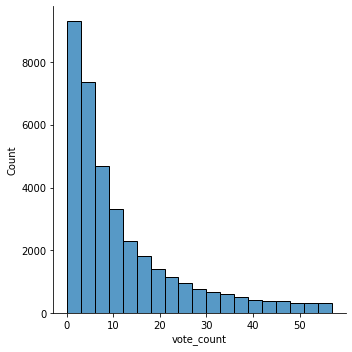

In [ ]:
# Step 2: drop movies that not many people have watched as it can create bias 
# from the graph, we believe 3 is a decent threshold 
sns.displot(movies_df, x = "vote_count", bins = [i for i in range(0, 60, 3)])
vote_threshold = 3
movies_df = movies_df[movies_df['vote_count'] >= vote_threshold]

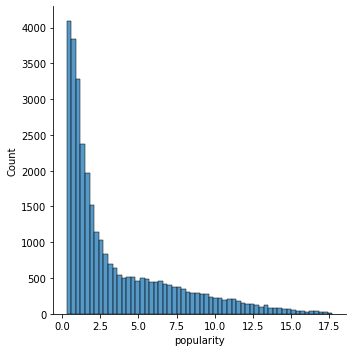

In [ ]:
# Step 3: drop non-popular movies as they will likely not be recommended
# from the graph, we believe 0.3 is a decent threshold 
movies_df['popularity'] = movies_df['popularity'].apply(lambda x : float(x))
sns.displot(movies_df, x = "popularity", bins = [i*0.3 for i in range(1, 60)])
popular_threshold = 0.6
movies_df = movies_df[movies_df['popularity'] >= popular_threshold]

Notice that both the genres and production companies columns have their inputs as strings/series

We want to reformat it into array of words for operations in the following sections

In [ ]:
# Step 4 : convert str --> [array of words]
# (Drop rows containing null values, i.e. those without a genre or production companies)
movies_df['genres'] = movies_df['genres'].apply(lambda x : str_parser(x))
movies_df.dropna(inplace=True)

movies_df['production_companies'] = movies_df['production_companies'].apply(lambda x : str_parser(x))
movies_df.dropna(inplace=True)

### 1.3 Joining Keywords and Movies

As described above, the dataframe **keywords** contains keywords that are used to describe movies in our database. 

Intuitively, we can imagine that the keywords for different movies can be included into the movies dataframe as a 'keywords' column. 

This helps us better maintain information as there are less dataframes to manage.  

We are joining the keyword df to **movie** df on the unique movie ID

In [ ]:
# join movies_df and keywords_df 

# "string-ify" each of the element in the follwing arrays
movies_df['genres'] = movies_df['genres'].apply(lambda x : str(x))
movies_df['production_companies'] = movies_df['production_companies'].apply(lambda x : str(x))
keywords_df['keywords'] = keywords_df['keywords'].apply(lambda x : str(x)) 

query = '''
select m.id, title, 
production_companies, genres,
keywords, popularity, 
vote_average, vote_count
from movies_df as m
join keywords_df as k
on m.id = k.id
'''

movies_df = ps.sqldf(query, locals())

### 1.4 Cleansing Ratings

The rating dataframe contains the data of interests that we want to look at - since we want to group people into different cluster. 

Let's first take a look at how many data there are! 

In [ ]:
len(ratings_df)

26024289

From the code above, we can see there are 26 million+ rows. That is a LOT of rows. 

Do we need all that information? Probably not! We believe 1 million rows will also suffice. 

It turns out the raw data for ratings is sorted by user id, and taking 10,000 users is somewhere around 1 million rows. 

In [ ]:
# cleansing ratings 

# Step 1 : ratings_df is a very large dataset sorted by userId 
# we do not need to use all of the users as part of training 
ratings_df = ratings_df[ratings_df['userId'] <= 10000]
len(ratings_df)

978527

Since this is a large dataframe, we also want to get rid of some columns that are not necessary

In [ ]:
# Step 2 : drop unnecessary columns 
ratings_df.drop(columns = ['timestamp'], inplace=True) 

Now we just want to double check and make sure that all the movies in ratings_df appear in movies_df (and vice versa)

In [ ]:
# Step 3 : get rid of ratings for movies not in movies_df 
movies_df['id'] = movies_df['id'].apply(lambda x : int(x))
ratings_df['movieId'] = ratings_df['movieId'].apply(lambda x : int(x))

query = '''
select * 
from ratings_df 
where movieId in (
  select id 
  from movies_df
)
'''

ratings_df = ps.sqldf(query, locals())

In [ ]:
# Step 4 : get rid of movies not rated in ratings_df 
query = '''
select * 
from movies_df 
where id in (
  select movieId 
  from ratings_df
)
'''

movies_df = ps.sqldf(query, locals())

In [ ]:
# Finally convert columns from a string to [array of words]
movies_df['genres'] = movies_df['genres'].apply(lambda x : eval("[" + x[1:-1] + "]")) 
movies_df['production_companies'] = movies_df['production_companies'].apply(lambda x : eval("[" + x[1:-1] + "]")) 
movies_df['keywords'] = movies_df['keywords'].apply(lambda x : eval("[" + x[1:-1] + "]"))

In [ ]:
# Make sure we have enough unique users before continuing
query = '''
select userId, count(movieId)
from ratings_df
group by userId
'''

ps.sqldf(query, locals()).shape


(9779, 2)

We believe that 9779 users would provide enough materials to train our model

## Step 2: Data Exploration & Visualization


From the section above, we have a **ratings** dataframe with info on 9779 unique users. 

We also have a **movies** dataframe with detailed information for each movie (including keywords).

So let's do some data visualization and try to get these 2 things : 

1) insights on our data 

2) remove rows and columns that seem unnecessary, or other further modification the data 




Along the way, we will also do some reformatting and work towards creating a dataframe to feed into our model later. 

For our machine learning model, we would like a genres and keywords dataframe that shows the average ratings for each genre/keyword based on the movies users have watched. 

We will need to reformat our current genres and keywords dataframe to average out values and make it compatible for machine learning. 

### 2.1 Popular (or, Successful) movie producers

Is it safe to assume that non-popular production companies didn't make any popular movies? Let's find out. 

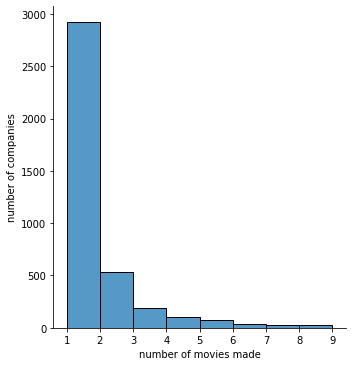

In [ ]:
# count the number of movies made by each production companies contained
companies = [company for companies in movies_df['production_companies'] for company in companies]
freq = collections.Counter(companies)

# plot
ax = sns.displot(freq, x = freq.values(), bins = [i for i in range(1, 10)])
ax.set(xlabel='number of movies made', ylabel='number of companies')

From the plot above, we can tell there are a lot of companies that have made just 1 movie.

Now let's check if any of these companies have produced a movie that turned out to be a success.

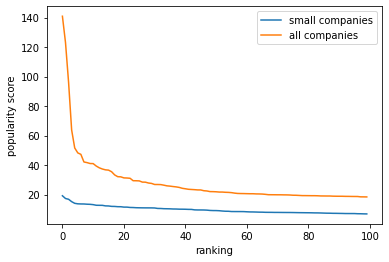

In [ ]:
large_companies = {k for k,v in freq.items() if v > 1}
number_of_rows = movies_df.count()[0]

popularity_by_small_companies = []
popularity_by_all_companies = []

for i in range(number_of_rows):
  small = True 
  for company in movies_df['production_companies'].iloc[i]:
    if company in large_companies:
      small = False 
      break 
  if small:
    popularity_by_small_companies.append(movies_df['popularity'].iloc[i])
   
plt.plot(sorted(popularity_by_small_companies, reverse=True)[:100], label='small companies')  
plt.plot(sorted(movies_df['popularity'], reverse=True)[:100], label='all companies') 
plt.xlabel('ranking'); plt.ylabel('popularity score')
plt.legend()

It appears small companies never made any movies that are within the top 100 popular movies.

However, looking at our graph, we can also observe that starting from the 40th most popular movie, there really isn't a large discrepency that proves small companies make only non-popular movies. 

Therefore, we can disregard production companies as a factor for recommending movies. 


In [ ]:
movies_df.drop(columns = ['production_companies'], inplace=True)

### 2.2 Genres & Individual User Rating

What do you think about when your friend ask you to pick a movie to watch? 

Rom-com? Crime? Action? 

Intuitively, genre seems to be quite an important factor when it comes to selection. 

Now let's take a look at that column more closely.

How many genres are identified in our dataset? What are their respective frequency of occuring? 

Let's take a look at the frequency for each genre in the data we have. 

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'count')

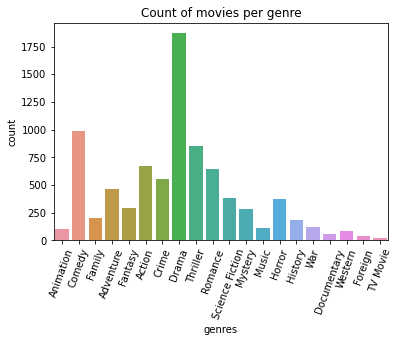

In [ ]:
# count 
all_genres = {}

for i in range(number_of_rows):
  for genre in movies_df['genres'].iloc[i]:
    all_genres[genre] = all_genres.get(genre, 0) + 1

# plot
sns.barplot(list(all_genres.keys()), list(all_genres.values()))
plt.xticks(rotation=70)

plt.title("Count of movies per genre")
plt.xlabel('genres')
plt.ylabel('count')  

It appears that there are a total of 20 genres identified in our database.

'Drama' appears to be the most common genre and 'TV Movies' appears to be the least common.  

Since genre plays an important role in movie selection and movie preference, we want to get information of individaul users' preference on them. 

Let's create a dataframe **genres_df** that has the *sum* of all ratings for each genre for each individual user.

genres_df will be eventually used to find other users who have similar preferences in the section running k-mean clustering 

In [ ]:
# Step 1 : create a copy of ratings_df and merge the 'genres' column from movies_df
genres_df = ratings_df.copy(deep=True)
movies_df['genres'] = movies_df['genres'].apply(lambda x : str(x))
movies_df['keywords'] = movies_df['keywords'].apply(lambda x : str(x))

query = '''
select *
from genres_df as g
join movies_df as m
on m.id = g.movieId 
'''

genres_df = ps.sqldf(query, locals())

# dropping unnecessary columns 
genres_df.drop(columns=['id', 'keywords', 'popularity',\
                        'vote_average', 'vote_count',\
                        'movieId', 'title'], inplace=True)

genres_df.sort_values(by=['userId'], inplace=True)

# reformatting entries such that they can be used for operations later
movies_df['genres'] = movies_df['genres'].apply(lambda x : eval("[" + x[1:-1] + "]")) 
genres_df['genres'] = genres_df['genres'].apply(lambda x : eval("[" + x[1:-1] + "]")) 
movies_df['keywords'] = movies_df['keywords'].apply(lambda x : eval("[" + x[1:-1] + "]")) 

In [ ]:
# Step 2 : append all 20 genres as columns 
number_of_rows = genres_df.count()[0]

for genre in all_genres.keys():
  genres_df[genre] = [0.0 for _ in range(number_of_rows)]

In [ ]:
# Step 3 : assign scores to the columns 
# note that we add a bias of 0.5 to help differentiate scores 
# and prevent them from being too clustered together 

bias = 0.5 
for i in range(number_of_rows):
  genres = genres_df['genres'].iat[i]
  val = genres_df['rating'].iat[i]
  for genre in genres:  
    genres_df[genre].iat[i] += val + bias 

The resulting dataframe is shown below. 

Again, genres_df shows the total sum of the ratings for each genre and for each user. 

We will later reformat the dataframe a bit further to make it compatible for K-Means Clustering.

In [ ]:
genres_df.head()

,userId,rating,genres,Animation,Comedy,Family,Adventure,Fantasy,Action,Crime,Drama,Thriller,Romance,Science Fiction,Mystery,Music,Horror,History,War,Documentary,Western,Foreign,TV Movie
0,1,1.0,"[Drama, Mystery, Romance]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.5,0.0,1.5,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1,4.0,[Comedy],0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1,4.0,[Comedy],0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1,4.5,"[Drama, Crime]",0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1,4.0,[Drama],0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 2.3 Frequency of Keywords



Genres are too generic? What else do you think about when you are choosing a movie? 

What if I want not just a rom-com, or something that is United States, girl, human,

*but something that has a lot of pink stuff, (Harvard) law school, CUTE dogs and 2000 vibe?*

We think that keywords would be a good place to look for indicator of whether a movie is something interests you.

However, given the plethora of keywords (~8000 in our dataset!) we are seeing in our dataset, it might be a good idea to see how they are distributed and count the number of distinct keywords. 

What you will find at the end of this section: 

1) Top 20 most popular (generic) keywords 

2) Top 20 least popular (archaic) keywords (might be affected by alphabetical order)

In [ ]:
#creating copies of movies and ratings so we don't mess with the original ones - just in case
movies_copy = movies_df.copy()

In [ ]:
# such that each keyword of each movie has their own row/place in the list first
keywords_list = movies_copy.explode("keywords")['keywords'].tolist()

In [ ]:
# initialise each of the keyword has frequency with 1 and then we group by them and do a count
temp = pd.DataFrame(keywords_list, columns=['keywords'])
temp['frequency'] = 1

# group words together so they have count of time they appeared = frequency
keywords_df = temp.groupby('keywords', as_index=False).count().sort_values('frequency', ascending=False)

# there are a total of 7949 number of keywords from our data
keywords_df['frequency'].count()

7949

Text(0.5, 1.0, 'top 20 frequently used keywords')

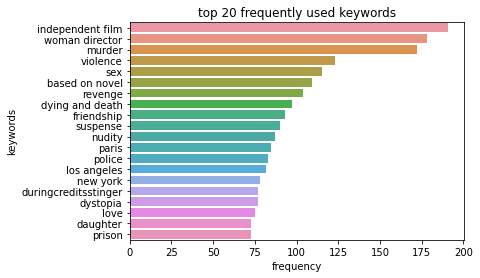

In [ ]:
sns.barplot(y='keywords', x='frequency', data=keywords_df.head(20))
plt.title("top 20 frequently used keywords")

From the above, we can see that there are frequently used words such as independent film, women director(!), murder, violence and sex. 

Let's explore this further by looking the number of movies each keywords are associated with.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


[Text(0, 0.5, 'Percentile'), Text(0.5, 0, 'Frequency')]

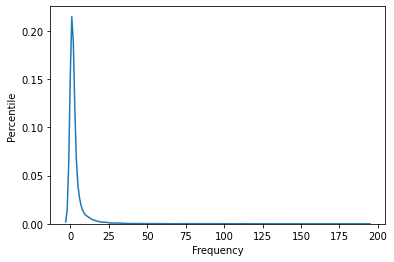

In [ ]:


# we visualize the distribution here 
ax = sns.distplot(keywords_df['frequency'], hist=False)
ax.set(xlabel='Frequency', ylabel='Percentile')

With a distribution plot, we can discover that a lot of the keywords are associated with only a few movies (highly specific keywords)

In [ ]:
# in the distribution, there are many highly specific keywords clustered together
# we start by using only 20% of the 'least' specific keywords 

# this brings us to a frequency of 4 keywords per movie 
keywords_df['frequency'].quantile(q=0.8)

4.0

In [ ]:
# there are 6555 keywords that appear less than of equal to 4 times
keywords_df[keywords_df['frequency'] <= 4]['keywords'].count()

6555

In [ ]:
# this generates the list of highly specific keywords
highly_specific_keywords = keywords_df[keywords_df['frequency']<=4]['keywords'].tolist()

Now, let's look at the not so specific keywords

In [ ]:
# we will focus on the "not so specific" keywords 
keywords_df = keywords_df[keywords_df['frequency']>4]
keywords = [word.lower() for word in keywords_list if word not in highly_specific_keywords]

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


[Text(0, 0.5, 'Percentile'), Text(0.5, 0, 'Frequency')]

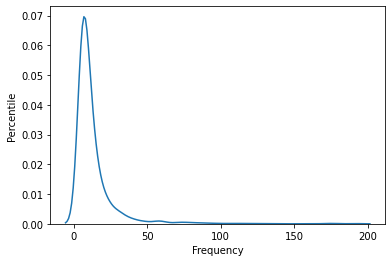

In [ ]:
# visualize the distribution for the new keywords and their frequency
ax = sns.distplot(keywords_df['frequency'], hist=False)
ax.set(xlabel='Frequency', ylabel='Percentile')

In [ ]:
# for now we use 1394 keywords  
# in a later section, we will reduce the number of keywords used 
len(keywords_df['frequency'])

1394

We have trimmed down the list of keywords we want to focus on to 1394 fro m ~8000. 

Let's draw a word cloud to see this with more clarity

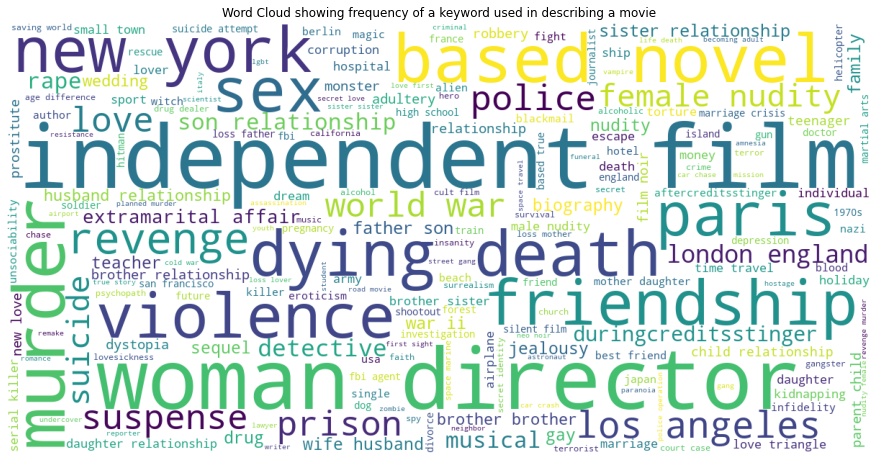

In [ ]:
from wordcloud import WordCloud, STOPWORDS 
    
comment_words = "" + " ".join(keywords) + " "

wordcloud = WordCloud(width = 1200, height = 600, 
                background_color ='white', 
                min_font_size = 10).generate(comment_words) 


plt.figure(figsize = (12, 6), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.title("Word Cloud showing frequency of a keyword used in describing a movie")
  
plt.show() 

From the above section, we now know the most popular keywords associated with different movies, as well as the least popular keywords. We can use these keywords later on for our machine learning model. 






### 2.4 Correlation between Frequency and Popularity of Keywords

We have seen frequently used keywords. However, can there be keywords that are frequently used to describe popular movies?

In other words, let's answer: Are frequently-used keywords associated with highly popular movies?

In [ ]:
#creating a smaller dataframe popular_keywords to that finds the mean popularity associated with each word

popular_keywords = movies_df[['keywords', 'popularity']].explode('keywords').reset_index()
popular_keywords = popular_keywords.groupby('keywords', as_index=False)[['keywords', 'popularity']].mean().\
                          sort_values('popularity', ascending=False)

# don't forget to filter out the generic/archic keywords we have listed in Section 2.3
filtered_popular_keywords = popular_keywords[popular_keywords['keywords'].isin(keywords)] 

Text(0.5, 1.0, 'top 20 keywords used to describe popular movies')

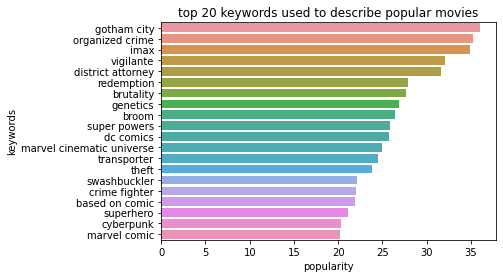

In [ ]:

sns.barplot(y='keywords', x='popularity', data=filtered_popular_keywords.head(20))
plt.title('top 20 keywords used to describe popular movies')

Not surprisingly, keywords used to describe popular keywords include gotham city, organised crime... 

Interestingly, district attorney is something of interest :)  

However, this is not the list we saw in Section 2.3 for most frequently used keywords. Let's get a Heat map to confirm our idea

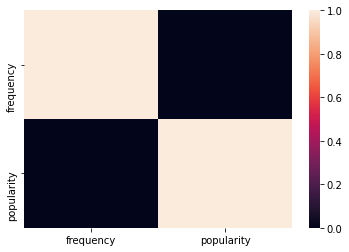

In [ ]:
query = '''
select k.keywords, k.frequency, f.popularity
from keywords_df as k
join filtered_popular_keywords as f
on k.keywords = f.keywords
'''

freq_pop = ps.sqldf(query)
sns.heatmap(freq_pop.corr(), vmin=0)

### 2.5 Correlation between Popularity, Vote Count, Vote Average

Correlation can potentially be dangerous for statistics and machine learning. Let's try to get rid of as much correlation as possible.

Some of the columns we are interested in exploring further includes correlation between popularity, vote count and vote average. We believe that these 3 columns measure similar things. In other words, we want to investigate: 

1) Is movie popularity associated with high vote count? If so, we can get rid of vote count

2) What about vote count and vote average? 

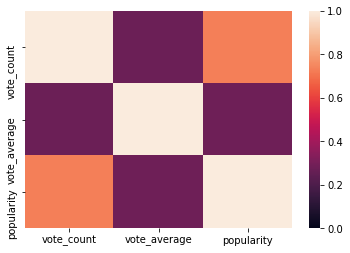

In [ ]:
temp = movies_df[['vote_count','vote_average','popularity']]
sns.heatmap(temp.corr(), vmin=0)

From the heatmap, we can see that vote count and popularity are strongly correlated. 

However, vote average and popularity are not strongly correlated. 

In [ ]:
# it's relatively intuitive to imagine why popularity and vote count are correlated
movies_df.drop(columns=['vote_count'], inplace=True)

It appears that there isn't a strong enough evidence to support that the average rating is correlated with popularity. 

## Step 3: Towards Machine Learning

### *What now?*

For our machine learning model, we would like a genres and keywords dataframe that shows the average ratings for each genre/keyword based on the movies users have watched. 

We will need to reformat our current genres and keywords dataframe to average out values and make it compatible for machine learning. 




### 3.1 Reformatting the Genres Dataframe

Recall that we already have a dataframe that has the sum of the ratings per genre based on movies each individual has seen.

In [ ]:
genres_df.head()

,userId,rating,genres,Animation,Comedy,Family,Adventure,Fantasy,Action,Crime,Drama,Thriller,Romance,Science Fiction,Mystery,Music,Horror,History,War,Documentary,Western,Foreign,TV Movie
0,1,1.0,"[Drama, Mystery, Romance]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.5,0.0,1.5,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1,4.0,[Comedy],0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1,4.0,[Comedy],0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1,4.5,"[Drama, Crime]",0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1,4.0,[Drama],0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


All we have to do is average out the values. 

In [ ]:
genres_df.drop(columns=['rating','genres'], inplace=True)

query = '''
select userId, avg("Animation") as animation, avg("Comedy") as comedy,
avg("Family") as family, avg("Adventure") as adventure, avg("Fantasy") as fantasy,
avg("Action") as action, avg("Crime") as crime, avg("Drama") as drama,
avg("Thriller") as thriller, avg("Romance") as romance,
avg("Science Fiction") as 'science fiction', avg(Mystery) as mystery, 
avg("Music") as music, avg("Horror") as horror, avg("History") as history, 
avg("War") as war, avg("Documentary") as documentary, avg("Western") as western,
avg("Foreign") as 'foreign', avg("TV Movie") as 'tv movie' 
from genres_df
group by userId
'''

genres_df = ps.sqldf(query, locals())
genres_df.head()

,userId,animation,comedy,family,adventure,fantasy,action,crime,drama,thriller,romance,science fiction,mystery,music,horror,history,war,documentary,western,foreign,tv movie
0,1,0.0,2.111111,0.000000,0.000000,0.000000,0.000000,0.555556,3.500000,0.000000,1.277778,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.000,0.0
1,2,0.0,0.970588,0.235294,0.941176,0.882353,1.000000,0.205882,2.058824,0.529412,0.794118,0.264706,0.470588,0.088235,0.529412,0.470588,0.205882,0.0,0.00,0.000,0.0
2,3,0.0,2.312500,0.000000,0.000000,0.437500,0.875000,1.187500,2.437500,0.750000,1.437500,0.437500,0.437500,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.000,0.0
3,4,0.0,1.000000,0.000000,0.675000,0.675000,0.800000,0.950000,2.100000,0.625000,1.100000,0.225000,0.400000,0.000000,0.225000,0.000000,0.000000,0.0,0.55,0.075,0.0
4,5,0.0,1.222222,0.000000,0.000000,0.000000,0.777778,1.222222,3.333333,1.388889,1.222222,1.111111,0.611111,0.000000,0.611111,0.000000,0.000000,0.0,0.50,0.000,0.0


### 3.2 Reducing Number of Keywords








For keywords, the process above is much less simpler as there are too many keywords. Before we proceed to averaging out ratings, we need to shorten the number of keywords a bit more than previous. 

Some candidates for removal are 'generic keywords'. Generic keywords will be words that get included excessively across many different genres.

In [ ]:
# build a dataframe to explore the number of times a keyword is associated with some genre 
keyword_to_genres = movies_df[['keywords', 'genres']] 
keyword_to_genres = keyword_to_genres.explode('genres').explode('keywords')

In [ ]:
# group by keywords 
# the more genres are associated with a particular keyword, the more generic the keyword is 
temp_df = keyword_to_genres.groupby('keywords', as_index=False).count().sort_values('genres', ascending = False)

Below we can see the top 20 generic keywords in our dataset and the distribution of frequencies.

Text(0.5, 1.0, 'top 20 generic keywords to describe movies of different genres')

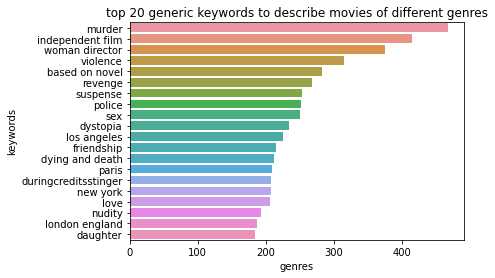

In [ ]:
sns.barplot(y='keywords', x='genres', data=temp_df.head(20))
plt.title("top 20 generic keywords to describe movies of different genres")

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


[Text(0, 0.5, 'Percentile'), Text(0.5, 0, 'Frequency')]

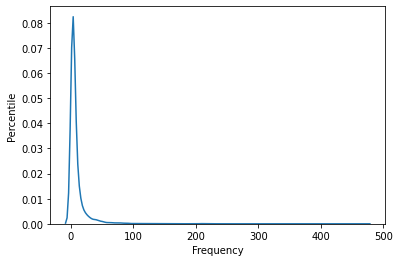

In [ ]:
# we visualize the distribution here 
ax = sns.distplot(temp_df['genres'], hist=False)
ax.set(xlabel='Frequency', ylabel='Percentile')

Based on the distribution above, a lot of words appear around 10 times. Certain outliers even go up to above 200 to 300 times. The outliers are what we want to get rid of. 

In [ ]:
# let's arbitrarily get rid of 15% of the most generic words 

# this would be a count of more than 13
upper_bound = temp_df['genres'].quantile(q=0.85)
upper_bound

13.0

In [ ]:
# we observe the non-generic words
keywords_to_observe = temp_df[temp_df['genres'] <= upper_bound]['keywords'].tolist()

We can focus on the less generic keywords so that we are not over-generalising the recommendation system.

Note that generic keywords do not necessarily entail just frequent keywords (and vice versa). Generic keywords must appear both 'frequently' and 'across many different genres'. 


In [ ]:
keywords = set(keywords_df['keywords'])

keywords_df = pd.DataFrame([word for word in keywords_to_observe if word in keywords], columns=['keywords'])

In [ ]:
# now we only look at 265 keywords! 
keywords_to_observe = set(keywords_df['keywords'].tolist())
len(keywords_to_observe)

265

Great! Now we reduced from more than 1300 keywords to 265! So now let's revisit the distribution of frequencies once more. 

In [ ]:
# let's look at the distribution for our non-generic keywords 
query = '''
select k.keywords, t.genres 
from keywords_df as k
join temp_df as t 
on k.keywords = t.keywords
'''

keywords_df = ps.sqldf(query, locals())

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


[Text(0, 0.5, 'Percentile'), Text(0.5, 0, 'Frequency')]

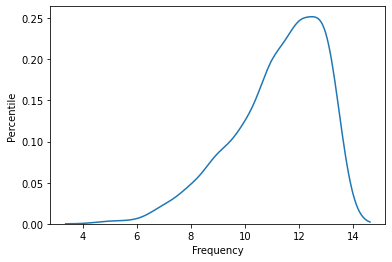

In [ ]:
# we visualize the distribution here 
ax = sns.distplot(keywords_df['genres'], hist=False)
ax.set(xlabel='Frequency', ylabel='Percentile')

Great! There are much less outliers. Now let's use this dataset to average out values as we did for genres. 

### 3.3 Reformatting the Keywords Dataframe


We can now look for the average rating per keyword based on different users.

The process is similar to what we did for genres :

1) find the sum of the ratings per keywords for each user 

2) average out the values 

In [ ]:
# Step 1 : create a copy of ratings_df and merge the 'keywords' column from movies_df
temp_df = ratings_df.copy(deep=True)
movies_df['genres'] = movies_df['genres'].apply(lambda x : str(x))
movies_df['keywords'] = movies_df['keywords'].apply(lambda x : str(x))

query = '''
select * from temp_df as t
join movies_df as m on t.movieId = m.id
'''

temp_df = ps.sqldf(query, locals())
temp_df.drop(columns=['id', 'genres', 'popularity','vote_average',\
                      'movieId', 'title'], inplace=True)
temp_df.sort_values(by=['userId'], inplace=True)

movies_df['genres'] = movies_df['genres'].apply(lambda x : eval("[" + x[1:-1] + "]")) 
movies_df['keywords'] = movies_df['keywords'].apply(lambda x : eval("[" + x[1:-1] + "]")) 
temp_df['keywords'] = temp_df['keywords'].apply(lambda x : eval("[" + x[1:-1] + "]"))

In [ ]:
# Step 2 : append all keywords as columns 
number_of_rows = temp_df.count()[0]

for keyword in keywords_to_observe:
  temp_df[keyword] = [0 for _ in range(number_of_rows)]

In [ ]:
# Step 3 : assign scores to the columns 
# note that we add a bias of 1 to help differentiate scores 
# and prevent them from being too clustered together 
bias = 1 
for i in range(number_of_rows):
  keywords = temp_df['keywords'].iat[i]
  val = temp_df['rating'].iat[i]
  for keyword in keywords:  
    if keyword in keywords_to_observe:
      temp_df[keyword].iat[i] += val + bias 

In [ ]:
# Step 4 : create a dataframe similar to genres_df
temp_df.drop(columns=['rating','keywords'], inplace=True)

query = 'select userId,'
for keyword in keywords_to_observe: 
  query += ' ' + 'avg("' + keyword + '")' + ' as "' + keyword.lower() + '",'
query = query[:-1] + " from temp_df group by userId"

keywords_df = ps.sqldf(query, locals())

The resulting dataframe is shown below. 

In [ ]:
keywords_df.head()

,userId,cult classic,splatter,world champion,ambulance,poker,bomb planting,manager,transporter,office,cinema,housekeeper,oklahoma,slum,education,plastic surgery,news broadcast,propaganda,relation,medicine,beating,penalty,city,lake,modern society,impotence,abuse,video nasty,difficult childhood,inheritance,self-destruction,class differences,berlin wall,basketball,lsd,generations confilct,bounty,fiancé,ex-con,vatican,...,gold rush,ranch,based on true events,single parent,øverste hylde,petrol,haunted house,war ship,summer camp,country estate,regret,settler,lion,guerrilla,yuppie,voyeur,guillotine,orgasm,assistant,political,devil,screwball comedy,pub,fog,beheading,drag,painter,older woman younger man relationship,found footage,puppet,ax,scholarship,father murder,unexpected happiness,german democratic republic,military officer,independence,skateboarding,marshal,sadomasochism
0,1,0.0,0.0,0.666667,0.0,0.000000,0.0,0.0,0.666667,0.0,0.0,0.00,0.0,0.000,0.0,0.0,0.0,0.0,0.555556,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.352941,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.235294,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.352941,0.0,0.0,0.0,0.0,0.0
2,3,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.625,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.625000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,4,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.25,0.0,0.000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.100000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,5,0.0,0.0,0.000000,0.0,0.666667,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


### 3.4 Correlation within Genre and Keywords 

Now let's discover if there are correlations between genres, and then check this again for keywords. 

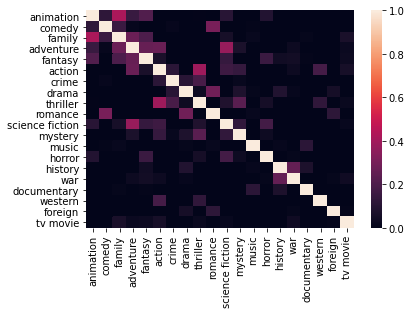

In [ ]:
# check the correlation between genres 
genres_copy = genres_df.drop(columns=['userId'])
sns.heatmap(genres_copy.corr(), vmin=0)

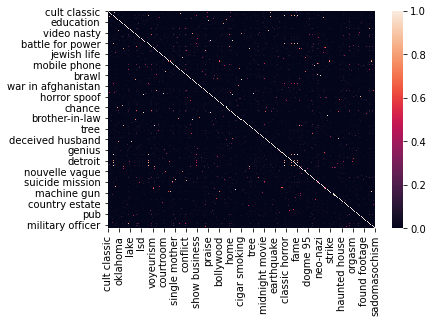

In [ ]:
# check the correlation between keywords
keywords_copy = keywords_df.drop(columns=['userId'])
sns.heatmap(keywords_copy.corr(), vmin=0)

Overall, it seems safe to say that there is not a significant correlation between different genres and keywords. 

We can now use our genres and keywords dataframe for k-Means Clustering. 

### 3.5 Building the Final Dataframe

Now that we have all our dataframes ready, all we have to do is to merge them into one large dataframe that will get processed by our k-Means model. 

For now, we drop the popularity score and vote count, but they will be used again when recommending the most popular movie in a cluster of users. 

In [ ]:
query = '''
select * from genres_df as g
join keywords_df as k on 
g.userId = k.userId   
'''

tmp = ps.sqldf(query, locals())
final_df = tmp.loc[:, ~tmp.columns.duplicated()]

# results are shown below 
final_df.head()

,userId,animation,comedy,family,adventure,fantasy,action,crime,drama,thriller,romance,science fiction,mystery,music,horror,history,war,documentary,western,foreign,tv movie,cult classic,splatter,world champion,ambulance,poker,bomb planting,manager,transporter,office,cinema,housekeeper,oklahoma,slum,education,plastic surgery,news broadcast,propaganda,relation,medicine,...,gold rush,ranch,based on true events,single parent,øverste hylde,petrol,haunted house,war ship,summer camp,country estate,regret,settler,lion,guerrilla,yuppie,voyeur,guillotine,orgasm,assistant,political,devil,screwball comedy,pub,fog,beheading,drag,painter,older woman younger man relationship,found footage,puppet,ax,scholarship,father murder,unexpected happiness,german democratic republic,military officer,independence,skateboarding,marshal,sadomasochism
0,1,0.0,2.111111,0.000000,0.000000,0.000000,0.000000,0.555556,3.500000,0.000000,1.277778,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.000,0.0,0.0,0.0,0.666667,0.0,0.000000,0.0,0.0,0.666667,0.0,0.0,0.00,0.0,0.000,0.0,0.0,0.0,0.0,0.555556,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.970588,0.235294,0.941176,0.882353,1.000000,0.205882,2.058824,0.529412,0.794118,0.264706,0.470588,0.088235,0.529412,0.470588,0.205882,0.0,0.00,0.000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.235294,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.352941,0.0,0.0,0.0,0.0,0.0
2,3,0.0,2.312500,0.000000,0.000000,0.437500,0.875000,1.187500,2.437500,0.750000,1.437500,0.437500,0.437500,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.625,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,4,0.0,1.000000,0.000000,0.675000,0.675000,0.800000,0.950000,2.100000,0.625000,1.100000,0.225000,0.400000,0.000000,0.225000,0.000000,0.000000,0.0,0.55,0.075,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.25,0.0,0.000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.100000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,5,0.0,1.222222,0.000000,0.000000,0.000000,0.777778,1.222222,3.333333,1.388889,1.222222,1.111111,0.611111,0.000000,0.611111,0.000000,0.000000,0.0,0.50,0.000,0.0,0.0,0.0,0.000000,0.0,0.666667,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


Additionally, let's create a users dataframe to show all of the movies the user has seen.  



In [ ]:
# create a user dataframe to show all movies a user has seen 
movies_df['genres'] = movies_df['genres'].apply(lambda x : str(x))
movies_df['keywords'] = movies_df['keywords'].apply(lambda x : str(x))

query = '''
select * 
from ratings_df
join movies_df 
on id = movieId
'''

tmp = ps.sqldf(query, locals())
tmp.drop(columns=['rating','id', 'genres', 'keywords', 'popularity', 'vote_average','title'], inplace=True)

movies_df['genres'] = movies_df['genres'].apply(lambda x : eval("[" + x[1:-1] + "]")) 
movies_df['keywords'] = movies_df['keywords'].apply(lambda x : eval("[" + x[1:-1] + "]")) 

In [ ]:
curr_user = 1
curr_movies = []
number_of_rows = tmp.count()[0]

all_users = []
all_movies = []

for i in range(number_of_rows):
  if curr_user != tmp['userId'].iat[i]:
    all_users.append(curr_user); all_movies.append(curr_movies)
    curr_user = tmp['userId'].iat[i]; curr_movies = []

  if curr_user == tmp['userId'].iat[i]:
    curr_movies.append(tmp['movieId'].iat[i])

all_users.append(curr_user)
all_movies.append(curr_movies)

In [ ]:
users_df = pd.DataFrame(list(zip(all_users, all_movies)), columns=["userId","movieIds"])

# results are shown below 
users_df.head()

,userId,movieIds
0,1,"[110, 147, 858, 1246, 1968, 2762, 2959, 4226, ..."
1,2,"[5, 25, 58, 64, 79, 141, 260, 339, 377, 605, 6..."
2,3,"[480, 500, 527, 858, 1092, 1968, 3101, 4474]"
3,4,"[223, 415, 648, 1422, 1597, 1644, 1645, 1732, ..."
4,5,"[296, 541, 750, 858, 1254, 1945, 2163, 3079, 3..."


Let's utilize these three dataframes to create a recommendation system : </br>
1. movies_df </br>
2. users_df </br>
3. final_df 
 

## Step 4: Unsupervised Machine Learning with K-Means Clustering


Now that we have build machine-learning-friendly dataframes, we can begin the central part of our project: building a kMeans clustering model to divide users into clusters and recommend movies accordingly. 

Note that there are clustering methods other than kMeans clustering (e.g. hierarchical clustering, which is covered in class, and spectral clustering, which is a graph-theory based clustering method), but we chose to focus on kMeans since our dataframe is rather big. 

Hierarchical clustering methods require building a n by n distance matrix (n = num of observations), which can be clumsy and slow when n is large (like in our case). On the other hand, spectral clustering has time complexity of O(n^3), and it takes forever to run it on our data

### 4.1 Preprocessing: Normalization and PCA


One final step before building the kMeans model is preprocessing the data. This consists of two steps: 

(1) Scaling/normalizing

(2) Dimensionality reduction.


For (1), we have tried different scalers/normalizers on our data, and eventually discovered that normalize() works best (compared to StandardScaler() and MinMaxScaler()). We suppose that this is because much of our data does not have a natural Gaussian shape. 

In [ ]:
# save user_ids for use later 
user_ids = final_df['userId']

# set userIds as index (we're not using those values in kMeans)
final_df = final_df.set_index("userId")

In [ ]:
# normalizing the data
normalized_result = normalize(final_df)

After normalization, we apply PCA to our data for dimensionality reduction. The following explained variance ratio graph indicates that we should set n_component to around 50.

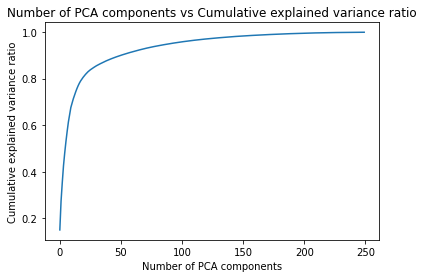

In [ ]:
# Plotting the explained variance ratio to help determine the number of components to use
pca = PCA(n_components = 250)
pca_result = pca.fit_transform(normalized_result)
cum_var = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cum_var)
plt.title("Number of PCA components vs Cumulative explained variance ratio")
plt.xlabel("Number of PCA components")
plt.ylabel("Cumulative explained variance ratio")
plt.show()

In [ ]:
pca = PCA(n_components = 50)
pca_result = pca.fit_transform(normalized_result)

### 4.2 Selecting kMeans parameters with three evaluating metrics

#### Elbow Method with Sum of Squared Errors

The next step is choosing the number of clusters we would use in kMeans clustering. Here we apply three evaluation metrics: Sum of Squared Errors (SSE, covered in class), the Davies Bouldin Score, and the Calinski Harabasz Score.

**Note that running these codes take quite some time as we are repeating kMeans analysis for many times. So if you don't have much time, feel free to not run this part and jump to the next section. If you want to run the code to check validity of results, however, feel free to uncomment.**

In [ ]:
# distortions = []
# max_k = 50

# # Find optimal no. of clusters using elbow method
# for i in range(1, max_k + 1) :
#   km = KMeans(n_clusters = i, 
#               init = 'k-means++',
#               max_iter = 300,
#               random_state = 0)
#   km.fit(pca_result)
#   distortions.append(km.inertia_)

# plt.plot(range(1, max_k+1), distortions, marker = 'o')
# plt.title("Number of KMeans Clusters vs Sum of Squared Errors")
# plt.xlabel("Number of KMeans Clusters")
# plt.ylabel("Sum of Squared Errors")
# plt.show()

#### Davies Bouldin Score

The Davies Bouldin Score is another measure (beside SSE) we can use to evaluate the performance of kMeans cluster. 

According to sklearn documentation, the score is defined as "the average similarity measure of each cluster with its most similar cluster, where similarity is the ratio of within-cluster distances to between-cluster distances."

Lower Davies Bouldin scores indicate clusters that are farther apart and less dispersed, and therefore better clusters. Here we plot the DB score of the kMeans model against the number of clusters. 

In [ ]:
# scores = []
# for i in range(2, max_k + 1) :
#   km = KMeans(n_clusters = i, 
#               init = 'k-means++',
#               max_iter = 300,
#               random_state = 0)
#   km.fit(pca_result)
#   scores.append(davies_bouldin_score(pca_result, km.labels_))
# plt.plot(range(2, max_k + 1), scores)
# plt.title("Number of KMeans Clusters vs Davies Bouldin Score")
# plt.xlabel("Number of KMeans Clusters")
# plt.ylabel("Davies Bouldin Score")
# plt.show()

#### Calinski Harabasz Score

The Calinski Harabasz Score, also known as the Variance Ratio Criterion, is another sklearn-built-in evaluation metric for kMeans algorithms.

The score is defined as ratio between the within-cluster dispersion and the between-cluster dispersion. Lower scores indicate better performance. 

Similar to what we have done above, we plot score against n_clusters and try to find the elbow in the graph

In [ ]:
# scores = []
# for i in range(2, max_k + 1) :
#   km = KMeans(n_clusters = i, 
#               init = 'k-means++',
#               max_iter = 300,
#               random_state = 0)
#   km.fit(pca_result)
#   scores.append(metrics.calinski_harabasz_score(pca_result, km.labels_))
# plt.plot(range(2, max_k + 1), scores)
# plt.title("Number of KMeans Clusters vs Calinski Harabasz Score")
# plt.xlabel("Number of KMeans Clusters")
# plt.ylabel("Calinski Harabasz Score")
# plt.show()

The result of applying all three evaluation metrics indicates that the optimal number of clusters is quite large, i.e. around 20. This makes sense as we are trying to classify moviegoers, and it makes sense that there are many types of them. Let's use n_clusters = 20 and perform our kMeans model fitting.



### 4.3 Feeding Data into KMeans Model

Here we use initialization method = k-means++ after trying a few different ones. By comparing the evaluation metrics and running speed, we decided that k-means++ is better than alternatives such as random initialization.

In [ ]:
n_cluster = 20

## set up k_means model with pre-selected n_cluster 
km = KMeans(n_clusters = n_cluster, 
              init = 'k-means++',
              max_iter = 300,
              random_state = 0)
## fit our data to the kmeans model 
km.fit(pca_result)

## store cluster info in final_df
final_df['cluster'] = km.labels_

Let's evaluate our final kMeans model using the three metrics mentioned above. 

In [ ]:
sse = km.inertia_
db_score = davies_bouldin_score(pca_result, km.labels_)
ch_score = metrics.calinski_harabasz_score(pca_result, km.labels_)

print("The SSE of our final kMeans clusters are: " + str(sse))
print("The Davies Bouldin Score of our final kMeans clusters are: " + str(db_score))
print("The Calinski Harabasz Score of our final kMeans clusters are: " + str(ch_score))

The SSE of our final kMeans clusters are: 1306.0939023667504
The Davies Bouldin Score of our final kMeans clusters are: 2.2507732268021288
The Calinski Harabasz Score of our final kMeans clusters are: 348.1810075317542


The SSE is quite large compared to the values we saw in class, but we should keep in mind that we are clustering a df with 50 features and 9779 observations. It makes sense the the sum of errors (not the average error) is quite high.

### **Making sense of the Clusters**


Now that we have executed the kMeans clustering algorithm, we can start examining its results.

#### Number of users within each cluster

First, let's take a look at how many users are in each cluster.

In [ ]:
pd.DataFrame(final_df.groupby(['cluster']).count()['animation']).rename(columns={'animation':'count'})

,count
cluster,
0,2765
1,138
2,621
3,734
4,339
5,243
6,593
7,144
8,135


Text(0.5, 1.0, 'Number of Users in Each Cluster')

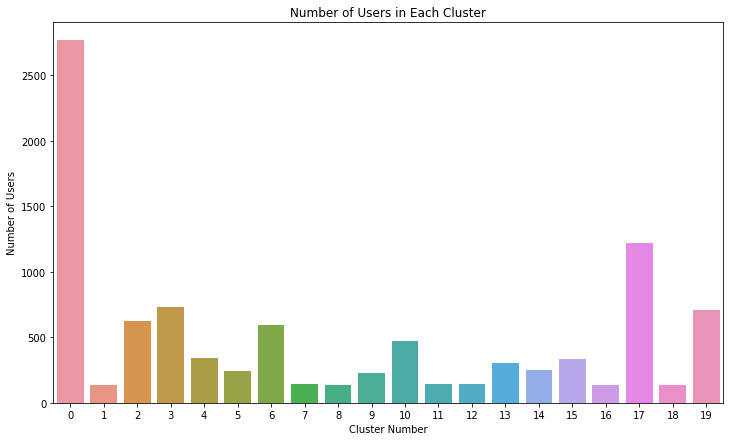

In [ ]:
plt.figure(figsize=(12,7))
axis = sns.barplot(x=np.arange(0,n_cluster,1),y=final_df.groupby(['cluster']).count()['animation'])
x=axis.set_xlabel("Cluster Number")
x=axis.set_ylabel("Number of Users")
axis.set_title("Number of Users in Each Cluster")

One can notice that there is one cluster with an especially large number of users. We hypothesize that this is because a good number of movie_watchers don't have particularly storng preferences on any genres/ keywords (i.e. they are "generic moviegoers", so they get all assigned to the same cluster.

A good sign is that every cluster has at least 100 users in it. This eliminates the worry that certain clusters only contain a few outliers and do not help with recommendation.

#### Most frequent genres within each cluster

Let's see what are the top genre / keyword preferences of users in each cluster


In [ ]:
avg_cluster = final_df.groupby(['cluster']).mean()


max_ratings = np.sort(avg_cluster.iloc[:, :20], axis=1)[:, -3:]

top_genre = []
second_genre = []
third_genre = []

for i in range(len(avg_cluster)):
  top_rating = max_ratings[i, 2]
  enum_rating = enumerate(avg_cluster.iloc[i, :20].tolist())
  top_genre.append(avg_cluster.columns[[j for j, n in enum_rating if n == top_rating][0]])

  second_rating = max_ratings[i, 1]
  enum_rating = enumerate(avg_cluster.iloc[i, :20].tolist())
  if (second_rating == top_rating):
    second_genre.append(avg_cluster.columns[[j for j, n in enum_rating if n == second_rating][1]])
  else:
    second_genre.append(avg_cluster.columns[[j for j, n in enum_rating if n == second_rating][0]])
  
  third_rating = max_ratings[i, 0]
  enum_rating = enumerate(avg_cluster.iloc[i, :20].tolist())
  if (third_rating == second_rating):
    third_genre.append(avg_cluster.columns[[j for j, n in enum_rating if n == third_rating][1]])
  else:
    third_genre.append(avg_cluster.columns[[j for j, n in enum_rating if n == third_rating][0]])


avg_cluster['top_genre'] = top_genre
avg_cluster['second_genre'] = second_genre
avg_cluster['third_genre'] = third_genre

# display the top three genres for the first 10 clusters
avg_cluster[['top_genre', 'second_genre', 'third_genre']].head(10)

,top_genre,second_genre,third_genre
cluster,,,
0,drama,comedy,thriller
1,comedy,crime,action
2,drama,thriller,action
3,drama,comedy,thriller
4,drama,crime,thriller
5,action,adventure,comedy
6,drama,thriller,action
7,drama,adventure,mystery
8,horror,thriller,science fiction


#### Most frequent keywords within each genre

In [ ]:
avg_cluster = final_df.groupby(['cluster']).mean()

max_keyword_ratings = np.sort(avg_cluster.iloc[:, 20:], axis=1)[:, -3:]

top_keyword = []
second_keyword = []
third_keyword = []

for i in range(len(avg_cluster)):
  top_keyword_rating = max_keyword_ratings[i, 2]
  enum_rating = enumerate(avg_cluster.iloc[i, 20:].tolist())
  top_keyword.append(avg_cluster.columns[[j for j, n in enum_rating if n == top_keyword_rating][0] + 16])

  second_keyword_rating = max_keyword_ratings[i, 1]
  enum_rating = enumerate(avg_cluster.iloc[i, 20:].tolist())
  if (second_keyword_rating == top_keyword_rating):
    second_keyword.append(avg_cluster.columns[[j for j, n in enum_rating if n == second_keyword_rating][1] + 16])
  else:
    second_keyword.append(avg_cluster.columns[[j for j, n in enum_rating if n == second_keyword_rating][0] + 16])
  
  third_keyword_rating = max_keyword_ratings[i, 0]
  enum_rating = enumerate(avg_cluster.iloc[i, 20:].tolist())
  if (third_keyword_rating == second_keyword_rating):
    third_keyword.append(avg_cluster.columns[[j for j, n in enum_rating if n == third_keyword_rating][1] + 16])
  else:
    third_keyword.append(avg_cluster.columns[[j for j, n in enum_rating if n == third_keyword_rating][0] + 16])

avg_cluster['top_keyword'] = top_keyword
avg_cluster['second_keyword'] = second_keyword
avg_cluster['third_keyword'] = third_keyword

# display the top three keywords for the first 10 clusters
avg_cluster[['top_keyword', 'second_keyword', 'third_keyword']].head(10)

,top_keyword,second_keyword,third_keyword
cluster,,,
0,cult classic,emigrant,forgiveness
1,education,erection,railroad
2,cult classic,education,abuse
3,chance,abuse,battle for power
4,cult classic,class,multiple storylines
5,emigrant,dictator,education
6,soul,ranch,school life
7,forgiveness,blow job,emigrant
8,dinner,son,political


We do see some differences between clusters, which is a good sign that our clustering algorithm is helping us distinguish users with different preferences. Now, let's go deeper and find out the favorite movies among each cluster.

#### Most Popular Movies Within Each Cluster

In order for our movie recommendation system to work, we need information about what movies the users in a cluster like to watch. The following helper functions help us figure those out:

1) The k_most_popular function, which uses the user_df to find the k-most popular movies within a group of users, excluding certain specified movies

2) The find_users function, which simply outputs the list of all users in each cluster 

3) The find_movie_name function, which basically translates movie ids to movie titles

In [ ]:
# Define a helper function that, given a list of users, outputs the k-th most
# popular movie among the group of users, excluding movies in an 
# excluded_list

def k_most_popular(user_list, k, excluded_list):
  list_of_movies = []

  # pool the movies that the users have watched 
  for user in user_list:
    movie_list = users_df[users_df['userId'] == user]["movieIds"].tolist()[0]
    for movie in movie_list :
      # exclude movies in excluded_list (avoid recommending watched movies)
      if movie not in excluded_list :
        list_of_movies.append(movie)

  # create hash buckets 
  bucket = [[] for _ in range(len(list_of_movies) + 1)]

  # record frequencies and sort according to frequencies 
  Count = collections.Counter(list_of_movies).items()  
  for movie, freq in Count: 
    bucket[freq].append(movie) 
  flat_list = list(itertools.chain(*bucket))

  return flat_list[::-1][:k]


In [ ]:
# Define a helper function that returns a list of users from a certain cluster
def find_users(cluster) :
  return final_df[final_df['cluster'] == cluster].reset_index()['userId'].tolist()

In [ ]:
# Define a helper function that finds the movie name corresponding to a movie ID
def find_movie_name(movie_id) :
  return movies_df[movies_df['id'] == movie_id]['title'].tolist()[0]

With these helper functions, let's find the three most popular movies within each cluster.

In [ ]:
top_movie = []
second_movie = []
third_movie = []

# for each cluster in the data 
for cluster in range(0, n_cluster): 
  # find the users in the cluster 
  cluster_users = find_users(cluster)

  # find the three most popular movies in the cluster 
  three_most_popular = k_most_popular(cluster_users, 3, [])

  # add the movies to the list 
  top_movie.append(find_movie_name(three_most_popular[0]))
  second_movie.append(find_movie_name(three_most_popular[1]))
  third_movie.append(find_movie_name(three_most_popular[2]))

top_three_movies = pd.DataFrame()
top_three_movies['Top Movie'] = top_movie
top_three_movies['Second Top Movie'] = second_movie
top_three_movies['Third Top Movie'] = third_movie

In [ ]:
top_three_movies.head(10)

,Top Movie,Second Top Movie,Third Top Movie
0,Terminator 3: Rise of the Machines,The Million Dollar Hotel,Solaris
1,License to Wed,My Name Is Bruce,I Love You to Death
2,Terminator 3: Rise of the Machines,The 39 Steps,The Million Dollar Hotel
3,The Conversation,The Hours,48 Hrs.
4,Young and Innocent,The Thomas Crown Affair,Get Carter
5,All the Way Boys,Men in Black II,Terminator 3: Rise of the Machines
6,The Passion of Joan of Arc,Beauty and the Beast,2001: A Space Odyssey
7,Solaris,Monsoon Wedding,Once Were Warriors
8,28 Days Later,28 Weeks Later,Frankenstein Unbound
9,Monsoon Wedding,Say Anything...,American Pie 2


### **Predicting Existing User's Movie Preference**

Before we go on to recommend movies to new users, let's see if we can make recommendations for existing users based on movies they have watched. We will 

(1) identify the cluster that the user belongs to, 

(2) find the top 5 movies of that cluster using k_most_popular() function, and 


(3) output the names of those movies using find_movie_name()

In [ ]:
# function that recommends a movie to an existing user (in the database)
# the movie would be one that the user hasn't watched
def recommend_movie_existing(existing_user) :

  if (existing_user <= 0) or (existing_user not in users_df['userId']):
    print("invalid user ID entered")
    return

  # find all the users in the same cluster 
  cluster_users = find_users(final_df.iloc[existing_user - 1, :]['cluster'])

  # movies that the user already have watched (we will exclude them)
  users_movie = users_df[users_df['userId'] == existing_user]["movieIds"].tolist()[0]

  print("Movies that the User have watched: \n")

  for i in users_movie:
    print(find_movie_name(i))

  print("\nMovies that we recommend: \n")

  for i in k_most_popular(cluster_users, 5, users_movie) :
    print(find_movie_name(i))

Let's use the function we develop to recommend movies for user #3

In [ ]:
recommend_movie_existing(3)

Movies that the User have watched: 

Monsoon Wedding
Reservoir Dogs
Once Were Warriors
Sleepless in Seattle
The Third Man
Fools Rush In
I Love You to Death
My Super Ex-Girlfriend

Movies that we recommend: 

The Million Dollar Hotel
License to Wed
Confession of a Child of the Century
The 39 Steps
Say Anything...


### **Recommending Movie to New Users**

When we have a new user we'd want to know their current favorite movies in order to give them recommendations. There are too many movies in the data to choose from, so we will just limit ourselves to movies from a certain list. Here we provide three different lists of movies to choose from:

1) A list of the 40 top-rated movies

2) A list of the 40 most popular movies

3) A random list of movies with popularity > 10

In [ ]:
## Find the top twenty movies by rating for the new user to choose from
movies_sorted = movies_df.sort_values(by = "vote_average", ascending = False)
# Exclude unpopular movies
movies_sorted = movies_sorted[movies_sorted['popularity'] > 10]
# number of movies we can select from - feel free to change it!
num_movies = 40
top_movies = movies_sorted[:num_movies].title
top_movies = np.sort(top_movies)

In [ ]:
## Find the top twenty movies by rating for the new user to choose from
movies_sorted_popularity = movies_df.sort_values(by = "popularity", ascending = False)

# number of movies we can select from - feel free to change it!
num_movies = 40
most_popular_movies = movies_sorted_popularity[:num_movies].title

# sort the list by alphabetical order to make selection easier
most_popular_movies = np.sort(most_popular_movies)

In [ ]:
random_movies = movies_df[movies_df['popularity'] > 10].sample(num_movies)['title']
random_movies = np.sort(random_movies)

In [ ]:
## Helper function that, given a list of movies that a new user has watched, 
## generate a dataframe in the format of final_df containing just the user's info

def create_new_user(list_of_movies, ratings_default = 4):
  # create new_user df with the same col names as final_df (except cluster)
  # assume the movies the user selects has a default ratings of "ratings_default"
  new_user = pd.DataFrame(columns = final_df.columns[:-1])
  for column in new_user.columns:
    new_user[column] = [0.0]

  for movie in list_of_movies:
    genres = movies_df[movies_df['title'] == movie]['genres'].iat[0]
    keywords = movies_df[movies_df['title'] == movie]['keywords'].iat[0]

    for genre in genres:
      new_user[genre.lower()].iat[0] += ratings_default / len(list_of_movies)
    for keyword in keywords:
      if keyword in keywords_to_observe:
        new_user[keyword.lower()].iat[0] += ratings_default / len(list_of_movies)
 
  return new_user 

In [ ]:
def predict_new_user(new_user_movies):
  new_user = create_new_user(new_user_movies)

  new_user = normalize(new_user)
  new_user = pca.transform(new_user)

  new_user_cluster = km.predict(new_user)[0]
  cluster_users = find_users(new_user_cluster)
  print("\nMovies that we recommend: \n")

  new_user_movie_ids = []
  for movie in new_user_movies:
    new_user_movie_ids.append(movies_df[movies_df['title'] == movie]['id'].iat[0])
    

  for i in k_most_popular(cluster_users, 5, new_user_movie_ids) :
    print(find_movie_name(i))
  
  print("\n")

With these helper functions, we can now give recommendations to a new user! Using the following IPython widgets, you can select your favorite movies among the top-rated movies, and our system will make recommendations based on that! 


In [ ]:
def create_recommender(movie_list):

  # a list to hold the movies selected by the new user (yes, that means you!)
  new_user_movies = []

  # create dropdown widget
  dropdown_movies = widgets.Dropdown(options = movie_list)

  # define an eventhandler and attach it to the widget 
  def dropdown_movies_eventhandler(change):
    if (new_user_movies == []) :
      print("\nHere is the list of Movies you Selected:\n")
    new_user_movies.append(change.new)
    display(change.new)

  dropdown_movies.observe(dropdown_movies_eventhandler, names='value')


  btn = widgets.Button(description='Recommend')

  def btn_eventhandler(obj):
    predict_new_user(new_user_movies)
    new_user_movies.clear()

  btn.on_click(btn_eventhandler)

  print("Choose Movies From the Below Dropdown List (you can choose multiple)")
  display(dropdown_movies)

  print("\nWhen you are done, click Recommend!")
  display(btn)

In [ ]:
movie_lists = ['Choose one from below:', 'Top Rated Movies', 
               'Most Popular Movies', 'Random Movies']
dropdown_list_selection = widgets.Dropdown(options = movie_lists)
def dropdown_list_eventhandler(change):
  # once the user has chosen a list, hide the list selection menu 
  dropdown_list_selection.layout.display = 'none'
  # display the movie list selected and let the user choose
  if (change.new == 'Top Rated Movies'):
    print("\n")
    create_recommender(top_movies)
  if (change.new == 'Most Popular Movies'):
    print("\n")
    create_recommender(most_popular_movies)
  if (change.new == 'Random Movies'):
    print("\n")
    create_recommender(random_movies)

# bind eventhandler and display dropdown menu  
dropdown_list_selection.observe(dropdown_list_eventhandler, names='value')
print("Here is our movie recommender!!")
display(dropdown_list_selection)

Here is our movie recommender!!


Dropdown(options=('Choose one from below:', 'Top Rated Movies', 'Most Popular Movies', 'Random Movies'), value…



Choose Movies From the Below Dropdown List (you can choose multiple)


Dropdown(options=('Ant-Man', 'Avengers: Age of Ultron', 'Back to the Future', 'Batman Begins', 'Blade Runner',…


When you are done, click Recommend!


Button(description='Recommend', style=ButtonStyle())


Here is the list of Movies you Selected:



'Harry Potter and the Goblet of Fire'

"Harry Potter and the Philosopher's Stone"

'Harry Potter and the Prisoner of Azkaban'

"Pirates of the Caribbean: At World's End"

"Pirates of the Caribbean: Dead Man's Chest"

'Pirates of the Caribbean: On Stranger Tides'

'Pirates of the Caribbean: The Curse of the Black Pearl'


Movies that we recommend: 

Cars
Asterix at the Olympic Games
The City of Lost Children
Hidalgo
The Wrong Trousers




Have fun playing with the Recommender above! We hope this helps you find your next movie to watch after the finals period :) 

Here are some results that we have got when trying out the recommender system: 

1) The "Young adult" Type:

      Here is the list of Movies you Selected:

      Harry Potter and the Goblet of Fire
      Harry Potter and the Philosopher's Stone
      Pirates of the Caribbean: At World's End
      Pirates of the Caribbean: Dead Man's Chest
      Pirates of the Caribbean: On Stranger Tides
      Pirates of the Caribbean: The Curse of the Black Pearl
      Monsters, Inc.
      Finding Nemo

      Movies that we recommend: 

      Cars
      The City of Lost Children
      Harry Potter and the Prisoner of Azkaban
      Asterix at the Olympic Games
      Hidalgo

2) The "Sci-fi" Type

      Here is the list of Movies you Selected:

      Star Wars
      The Empire Strikes Back
      The Dark Knight

      Movies that we recommend: 

      All the Way Boys
      Men in Black II
      King Kong vs. Godzilla
      Terminator 3: Rise of the Machines
      300

3）The "Romantic" Type 

(Recall that you can select a movie multiple times to indicate that you really like it)

      Here is the list of Movies you Selected:

      Life Is Beautiful
      Titanic
      Spirited Away
      Life Is Beautiful
      Titanic

      Movies that we recommend: 

      The Million Dollar Hotel
      License to Wed
      Once Were Warriors
      Monsoon Wedding
      Say Anything...

4) The "Reflective" Type

      Here is the list of Movies you Selected:

      Dead Poets Society
      The Shawshank Redemption
      One Flew Over the Cuckoo's Nest
      12 Angry Men
      Taxi Driver

      Movies that we recommend: 

      Rocky Balboa
      Local Color
      Confession of a Child of the Century
      Rocky V
      Gandhi

5) The "Comedy-loving" Type

      Here is the list of Movies you Selected:

      The Apartment
      City Lights
      Life Is Beautiful

      Movies that we recommend: 

      Monsoon Wedding
      Say Anything...
      American Pie 2
      Fools Rush In
      Bell, Book and Candle

6) The "Scorcese-afficionado" type ("Casino" is a Scorcese movie!)

      Here is the list of Movies you Selected:

      GoodFellas
      Taxi Driver

      Movies that we recommend: 

      Young and Innocent
      The Thomas Crown Affair
      Get Carter
      Casino
      Lonely Hearts

Of course, these type names are assigned by us, rather than the clustering algorithm. The algorithm doesn't tell us the exact "meaning" of the cluster, so there is always some need for human interpretation of the results. 

## **Summary**

### **Challenges**

1. Misleading columns and values 

One challenge we faced was that our dataset, while does not have many null values, started of with a lot of irrelevant columns that are not instrumental to our analyses. We had to spend a lot of time running cleaning and EDA to get rid of unecessary columns, and unecessary rows. 

2. Difficulty in evaluation

Another major challenge is difficulty in validation of our predictions. Since the model we built is an unsupervised machine learning model, it is difficult to evaluate how good our predictions are. With a little help of outside research, however, we came up with 3 different metrics for evaluations. 

3. K-mean clustering & High-dimension

Since k-mean clusteirng would have problems when it goes to high dimension, it doesn't work well with our original dataset. Moreover, large dataset also poses problem on processing. We started of with a dataset of more than 200 columns (without processing) to feed into the k-mean clustering model, which obviously isn't ideal. We needed trimming and normalizing such as PCA and filtering out generic keywords.

4. Assumptions 

Certain assumptions were necessary to make when doing the recommendation / building the kmeans model (e.g. there are natural clusters among users, hypothesizing the shape of the clusters, etc.). This could pose problem as to whether our model would acutally work - but seeing from the results, we are quite satisfied with what it comes up with so far :)

### **Potential Improvements**

1. More filtering? 

One thing you might have observed in our EDA is that the genre "Drama" is substantially higher than all other 19 genres, and almost all movies can call themselves Drama. If we want a more accurate prediction, perhaps we can try taking it away. Beside the "Drama" genre, we may also want to take away some more keywords (either too popular or too archiac) to further reduce the dimension of the final dataframe feed into the kmeans clustering. If we have more time, we should definitely continue fine-tuning the list of genres and features to include such that we eliminate all non-descriptive / non-informative ones. 

2. Other clustering methods? 

We used k-mean clustering (kmeans++ specifically) because of scale and efficiency consideration. However, there are other clustering methods which might be useful or even more accurate than what we have done. For example, we could try out hierachical clustering and spectral clusterings to see if the results would be different / more accurate. 


3. More information on users?

This is a restriction posed by the dataset we selected. We don't have much of an individual user's information beyond the movie he/she has watched and the rating given. However, if we have information on age, ethnicity, socioeconomic class/income background, gender, etc., we can run a supervised machine learning task to pre-define the type of user. 

With this information, we can also run a more accurate kmeans clustering to get more accurate model. 


4. More users? 

Currently, we are working with data provided by >10000 users. However, we could have more accurate model (but less efficient though) if we model it upon more users. 

5. Reduce columns?

Another improvement we could make is to potentially change the matrix format to a sparse matrix as many keywords do not apply for each user.   

THE END :D 